Домашняя работа к лекции 2 по курсу Компьютерное зрение.
---------
**Извлечение признаков изображения, поиск по картинкам**

Студента: **Помойницкого Евгения**

Группа: **DS 8**

**Задание:**
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

Обработку датасета и выделение фич на основе гистограммы оставляем из примера в задании.
---

In [128]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [129]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [130]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = test[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [131]:
test[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [132]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

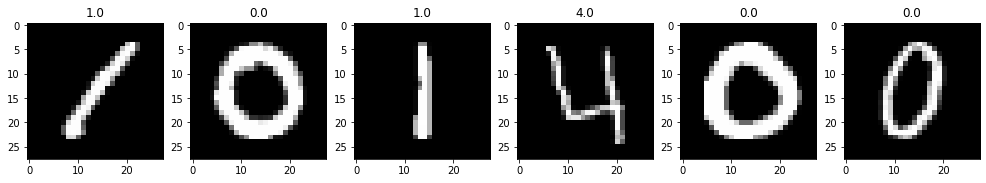

In [133]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [134]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [135]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [136]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [137]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

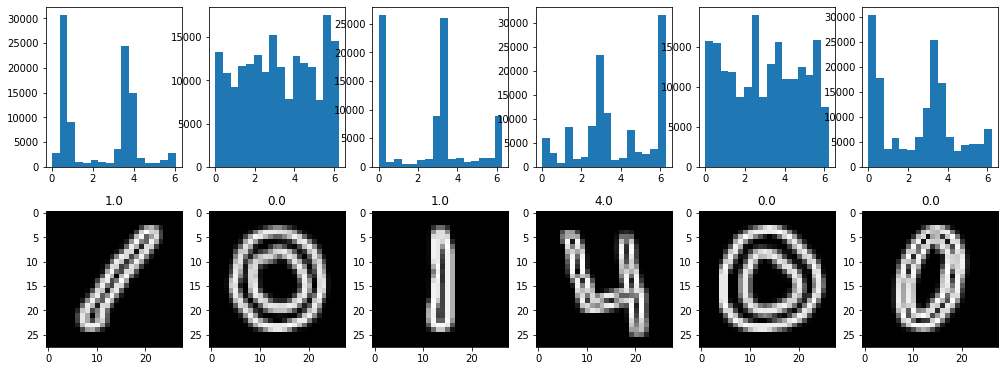

In [138]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [139]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [140]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [141]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [142]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Решение Домашнего задания
---

Применим к задаче классификатор "Решающее дерево" 
---
Поскольку тестовый датасет не размечен, мы не можем локально проверить качество модели. Разбиваем размеченную выборку на обучение и валидацию

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_hist, train_label, test_size=0.2, random_state=42)

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Попробуем найти оптимальную глубину дерева с помощью кросс-валидации. 

In [145]:
depths = np.arange(1,20)
grid = {'max_depth': depths}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [146]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  

In [147]:
gridsearch.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Применим параметры, полученные путем Кросс-валидаци**

In [148]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [149]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [150]:
y_pred = clf.predict(X_test)

In [151]:
accuracy_score(y_test, y_pred)

0.45880952380952383

**Значение метрики недостаточное по условиям задания.** Проверим, методом перебора, действительно ли кросс-валидация дала наилучшие гиперпараметры для классификатора.

In [157]:
for i in range (5,16):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('For Depth: {} Accuracy is: {:.3f}'.format(i, accuracy_score(y_test, y_pred)))

For Depth: 5 Accuracy is: 0.429
For Depth: 6 Accuracy is: 0.459
For Depth: 7 Accuracy is: 0.482
For Depth: 8 Accuracy is: 0.500
For Depth: 9 Accuracy is: 0.510
For Depth: 10 Accuracy is: 0.520
For Depth: 11 Accuracy is: 0.528
For Depth: 12 Accuracy is: 0.533
For Depth: 13 Accuracy is: 0.530
For Depth: 14 Accuracy is: 0.530
For Depth: 15 Accuracy is: 0.525


Несколько странно, но результат кросс-валидации оказался не оптимальным. **Путем перебора нашли лучшую глубину - 12.** Проверим точность при таком гиперпараметре

In [159]:
clf_final = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [160]:
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)

In [161]:
accuracy_score(y_test, y_pred)

0.5344047619047619

**Значение метрики accuracy улучшилось,** тем не менее, недостаточно для условий задания. 
Попробуем более продвинутый классификатор - Случайный лес.
---

In [162]:
from sklearn.ensemble import RandomForestClassifier

In [163]:
clf = RandomForestClassifier()

In [166]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [167]:
accuracy_score(y_test, y_pred)

0.6457142857142857

При использовании параметров по умолчанию, результат выглядит достаточным. Попробуем кросс-валидацией найти лучшие гиперпараментры

In [169]:
depths = np.arange(1,20)
grid = {'max_depth': depths}
gridsearch = GridSearchCV(RandomForestClassifier(), grid, scoring='neg_log_loss', cv=5)

In [170]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [171]:
gridsearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [172]:
clf_rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [173]:
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.645952380952381

Выведем первые несколько пар соответствия предсказания и разметки

In [174]:
for i in range(20):
    print('Predicted digit is {} for true digit {}'.format(y_pred[i], y_test[i]))

Predicted digit is 6.0 for true digit 8.0
Predicted digit is 1.0 for true digit 1.0
Predicted digit is 9.0 for true digit 9.0
Predicted digit is 7.0 for true digit 9.0
Predicted digit is 6.0 for true digit 8.0
Predicted digit is 2.0 for true digit 6.0
Predicted digit is 3.0 for true digit 2.0
Predicted digit is 2.0 for true digit 2.0
Predicted digit is 7.0 for true digit 7.0
Predicted digit is 1.0 for true digit 1.0
Predicted digit is 2.0 for true digit 6.0
Predicted digit is 3.0 for true digit 3.0
Predicted digit is 1.0 for true digit 1.0
Predicted digit is 0.0 for true digit 2.0
Predicted digit is 7.0 for true digit 7.0
Predicted digit is 8.0 for true digit 4.0
Predicted digit is 5.0 for true digit 3.0
Predicted digit is 3.0 for true digit 3.0
Predicted digit is 6.0 for true digit 6.0
Predicted digit is 4.0 for true digit 4.0


Применяем обученный классификатор 
---
на неразмеченном тестовом наборе и выводим первые шесть цифр

In [175]:
prediction = clf_rf.predict(test_hist)

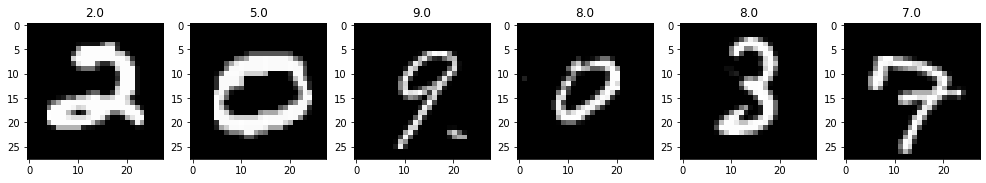

In [176]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    #subplot.set_title('%s' % y_pred[i - 1])
    subplot.set_title('%s' % prediction[i-1])

In [127]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction, 1):
        dst.write('%s,%s\n' % (i, int(p)))